<a href="https://www.kaggle.com/code/georgistan/co2-emmision-by-vehicles-linear-regression?scriptVersionId=167008569" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Dataset description

This dataset captures data over a period of 7 years of how CO2 emissions by a vehicle can vary with the different features.

Features:
- Model

    - 4WD/4X4 = Four-wheel drive
    - AWD = All-wheel drive
    - FFV = Flexible-fuel vehicle
    - SWB = Short wheelbase
    - LWB = Long wheelbase
    - EWB = Extended wheelbase

- Transmission

    - A = Automatic
    - AM = Automated manual
    - AS = Automatic with select shift
    - AV = Continuously variable
    - M = Manual
    - 3 - 10 = Number of gears

- Fuel type

    - X = Regular gasoline
    - Z = Premium gasoline
    - D = Diesel
    - E = Ethanol (E85)
    - N = Natural gas

- Fuel Consumption (L/100 km)

- CO2 Emissions (g/km)

[A video regarding the CO2 emissions across the globe.](https://futurism.com/the-byte/nasa-video-carbon-emissions-visible) Hard watch.

[Latest CO2 global emission levels.](https://www.co2.earth/daily-co2)

> Given these high continual levels (>425 ppm CO2), it would be interesting to see how vehicles impact them.

# Data pre-processing and exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

emissions = pd.read_csv("/kaggle/input/co2-emission-by-vehicles/CO2 Emissions_Canada.csv")
emissions.head()

,Make,Model,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km)
0,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196
1,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221
2,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136
3,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255
4,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244


In [2]:
emissions.shape

(7385, 12)

## Check if the combined fuel consumption is well calculated

In [3]:
# extract relevant columns from the dataset
city_consumption = emissions['Fuel Consumption City (L/100 km)']
highway_consumption = emissions['Fuel Consumption Hwy (L/100 km)']
combined_consumption = emissions['Fuel Consumption Comb (L/100 km)']

# combine the city and highway consumption into a matrix
consumption_matrix = np.column_stack([city_consumption, highway_consumption])

consumption_matrix

array([[ 9.9,  6.7],
       [11.2,  7.7],
       [ 6. ,  5.8],
       ...,
       [11.7,  8.6],
       [11.2,  8.3],
       [12.2,  8.7]])

### Linear regression to find coefficients that describe the relationship between city, highway, and combined fuel consumption

The coefficients obtained from the linear regression represent the "amounts" or "weights" (importance factors) of city and highway fuel consumption that contribute to the combined fuel consumption.

> For instance, if the coefficient for city fuel consumption is 0.3, i.e. for every unit increase in city fuel consumption, the combined fuel consumption is expected to increase by 0.3 units.

- used "least squares" method from the linear algebra numpy module (np.linalg) - typically used in linear regression to find the best-fitting line through a set of data points; thus, minimizing the sum of squared differences between the predicted and actual values
- this returns a *tuple of 4 values*, reason being for tuple unpacking

In [4]:
# linear regression to find the relationship between city, highway, and combined consumption
# tuple unpacking; we're interested in the first value (the coeff) and the rest are ignored
coefficients, _, _, _ = np.linalg.lstsq(consumption_matrix, combined_consumption, rcond = None)

coefficients

array([0.54977202, 0.45035134])

- axis = 0 parameter below specifies that the averaging operation is performed along the rows i.e. for each column (feature), the weighted average is calculated (independently) across the rows

In [5]:
# calculate the weighted average of city and highway consumption using the obtained coefficients
weighted_avg = np.round(np.average([city_consumption, highway_consumption], weights = coefficients, axis = 0), 1)

# print calculated coefficients and compare with the actual combined consumption for the first five rows
print('Coefficients:', coefficients)
print('Weighted Average:', weighted_avg[:10])
print('Actual Combined Consumption:', list(combined_consumption.iloc[:10]))

# absolute difference between the actual and calculated combined consumption
difference = np.abs(combined_consumption - weighted_avg)

# average and maximum absolute difference
print('The average difference is:', np.round(np.average(difference), 3), '(L/100 km)')
print('The max difference is:', np.max(difference), '(L/100 km)')

Coefficients: [0.54977202 0.45035134]
Weighted Average: [ 8.5  9.6  5.9 11.1 10.6 10.  10.1 11.1 11.6  9.2]
Actual Combined Consumption: [8.5, 9.6, 5.9, 11.1, 10.6, 10.0, 10.1, 11.1, 11.6, 9.2]
The average difference is: 0.017 (L/100 km)
The max difference is: 0.5 (L/100 km)


- the first coefficient (0.54977202) corresponds to city fuel consumption
- the second coefficient (0.45035134) corresponds to highway fuel consumption
- they indicate the contribution of each feature to the prediction of the combined fuel consumption
- each value in the weighted average array corresponds to a predicted combined fuel consumption for the corresponding data point
- the average difference represents the average absolute difference between the predicted (weighted average) and actual values of combined fuel consumption across all data points, which in this case is pretty low

> To sum up, the discrepancies seem relatively low, especially considering the average difference. 

The calculations for the "Fuel Consumption Comb (mpg)" seem off since, since the conversion between miles per gallon (mpg) and liters per 100 kilometers (L/100 km) is given by the formula:

mpg = $\frac{235.215}{L/100 \, \text{km}}$

Therefore, for 8.5 L/100km we would have 27.67 mpg, instead of 33. This is why we will drop this column and only use the one in L/100km. 


In [6]:
emissions = emissions.drop('Fuel Consumption Comb (mpg)', axis = 1)

### Check for missing data and percentages

In [7]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum() / data.count() * 100).sort_values(ascending = False)
    
    return pd.concat([total, percent], axis = 1, keys = ['Total values missing', 'Percent of data missing'])

missing_data(emissions)

,Total values missing,Percent of data missing
Make,0,0.0
Model,0,0.0
Vehicle Class,0,0.0
Engine Size(L),0,0.0
Cylinders,0,0.0
Transmission,0,0.0
Fuel Type,0,0.0
Fuel Consumption City (L/100 km),0,0.0
Fuel Consumption Hwy (L/100 km),0,0.0
Fuel Consumption Comb (L/100 km),0,0.0


In [8]:
emissions.describe()

,Engine Size(L),Cylinders,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),CO2 Emissions(g/km)
count,7385.000000,7385.000000,7385.000000,7385.000000,7385.000000,7385.000000
mean,3.160068,5.615030,12.556534,9.041706,10.975071,250.584699
std,1.354170,1.828307,3.500274,2.224456,2.892506,58.512679
min,0.900000,3.000000,4.200000,4.000000,4.100000,96.000000
25%,2.000000,4.000000,10.100000,7.500000,8.900000,208.000000
50%,3.000000,6.000000,12.100000,8.700000,10.600000,246.000000
75%,3.700000,6.000000,14.600000,10.200000,12.600000,288.000000
max,8.400000,16.000000,30.600000,20.600000,26.100000,522.000000


- The mean for CO2 emissions is 250 g/km
- No matter the parameter, Fuel Consumption Hwy (L/100 km) < Fuel Consumption Comb (L/100 km)

## Check for duplicated data

In [9]:
emissions_duplicated = emissions[emissions.duplicated() == True]
emissions_duplicated

#emissions.duplicated().sum()

,Make,Model,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),CO2 Emissions(g/km)
1075,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,244
1076,ACURA,RLX,MID-SIZE,3.5,6,AS6,Z,11.9,7.7,10.0,230
1081,ALFA ROMEO,4C,TWO-SEATER,1.8,4,AM6,Z,9.7,6.9,8.4,193
1082,ASTON MARTIN,DB9,MINICOMPACT,5.9,12,A6,Z,18.0,12.6,15.6,359
1084,ASTON MARTIN,V8 VANTAGE,TWO-SEATER,4.7,8,AM7,Z,17.4,11.3,14.7,338
...,...,...,...,...,...,...,...,...,...,...,...
7356,TOYOTA,Tundra,PICKUP TRUCK - STANDARD,5.7,8,AS6,X,17.7,13.6,15.9,371
7365,VOLKSWAGEN,Golf GTI,COMPACT,2.0,4,M6,X,9.8,7.3,8.7,203
7366,VOLKSWAGEN,Jetta,COMPACT,1.4,4,AS8,X,7.8,5.9,7.0,162
7367,VOLKSWAGEN,Jetta,COMPACT,1.4,4,M6,X,7.9,5.9,7.0,163


In [10]:
emissions.shape

(7385, 11)

There is almost 15% of duplicates, which I think it is quite much. 
Let's see the number of unique values of 'CO2 Emissions(g/km)' for each combination of the specified columns.

In [11]:
sum(emissions_duplicated.groupby(by =['Make','Model','Vehicle Class','Engine Size(L)','Cylinders','Transmission','Fuel Type'])['CO2 Emissions(g/km)'].nunique())

998

I will consider the duplicates as instances that happen to have the same values instead of dropping them, since I don't think they will impact the results.

# Data visualization

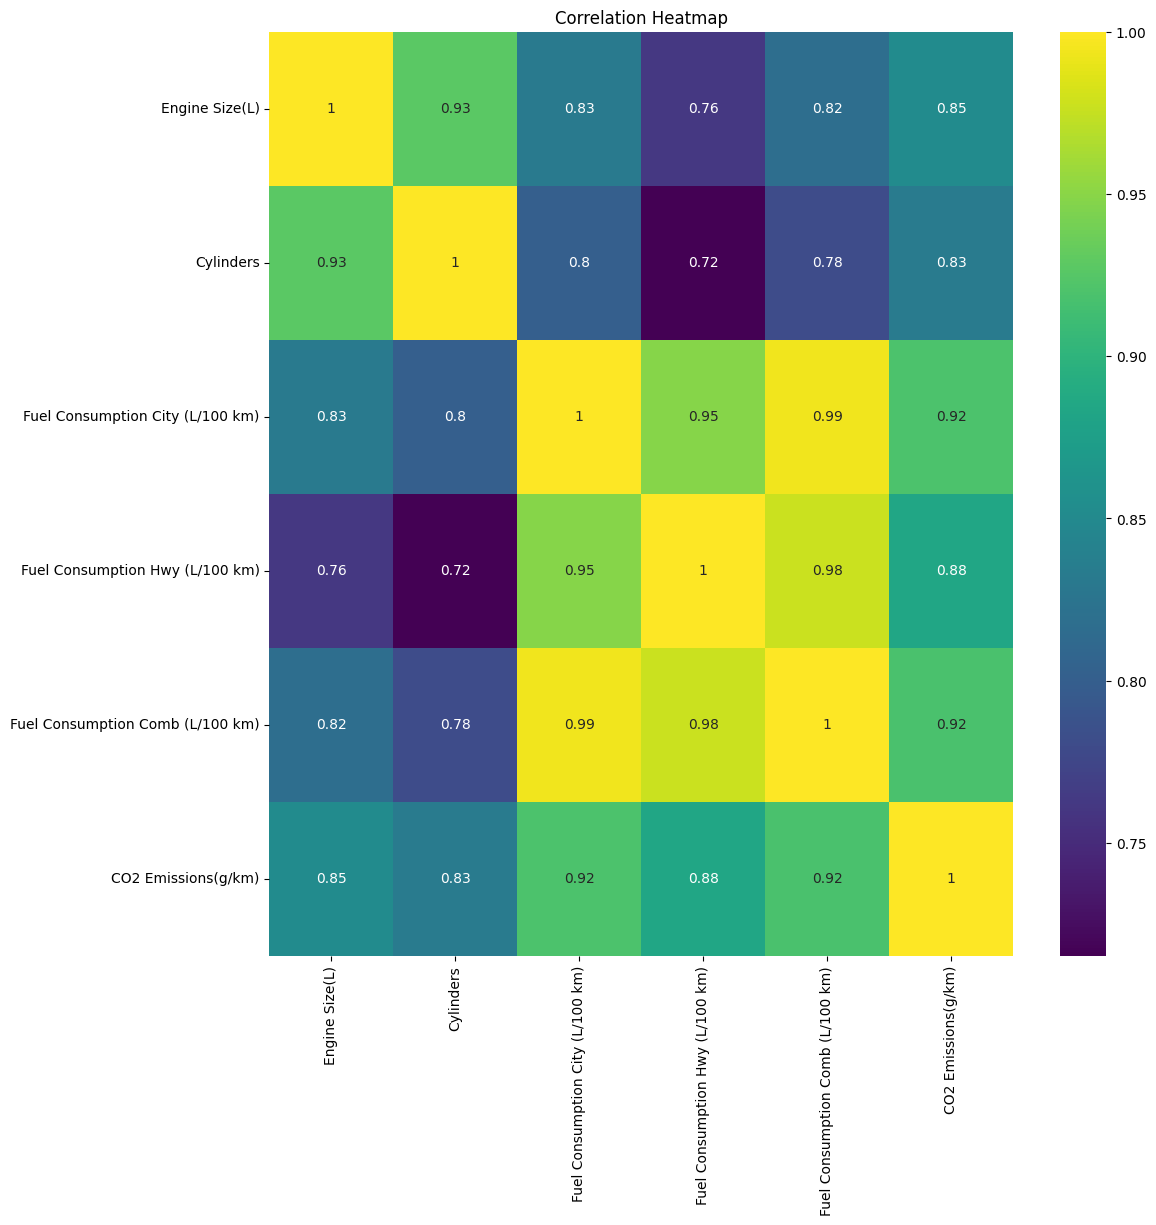

In [12]:
# heatmap to see the correlations between numeric values
numeric_columns = emissions.select_dtypes(exclude=['object'])
correlation_matrix = numeric_columns.corr()
plt.figure(figsize = (12, 12))
sns.heatmap(correlation_matrix, cmap = 'viridis', annot = True)
plt.title('Correlation Heatmap')
plt.show()

- All features impact negatively the CO2 emissions, especially the fuel consumption and the engine size; plus, the higher the number of cylinders, the higher the engine size.

In [13]:
# statistics for columns with object (string) data types

emissions.describe(include=['O'])

,Make,Model,Vehicle Class,Transmission,Fuel Type
count,7385,7385,7385,7385,7385
unique,42,2053,16,27,5
top,FORD,F-150 FFV 4X4,SUV - SMALL,AS6,X
freq,628,32,1217,1324,3637


## Normality

Since Linear regression assumes that the residuals (the differences between the observed and predicted values) are normally distributed, I will check if the data is normally distributed.


> Box plots to visually represent the distribution of data and highlight potential outliers (points beyond the "whiskers" of the box plot are considered outliers),

In [14]:
emissions.isnull().sum().any()

False

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


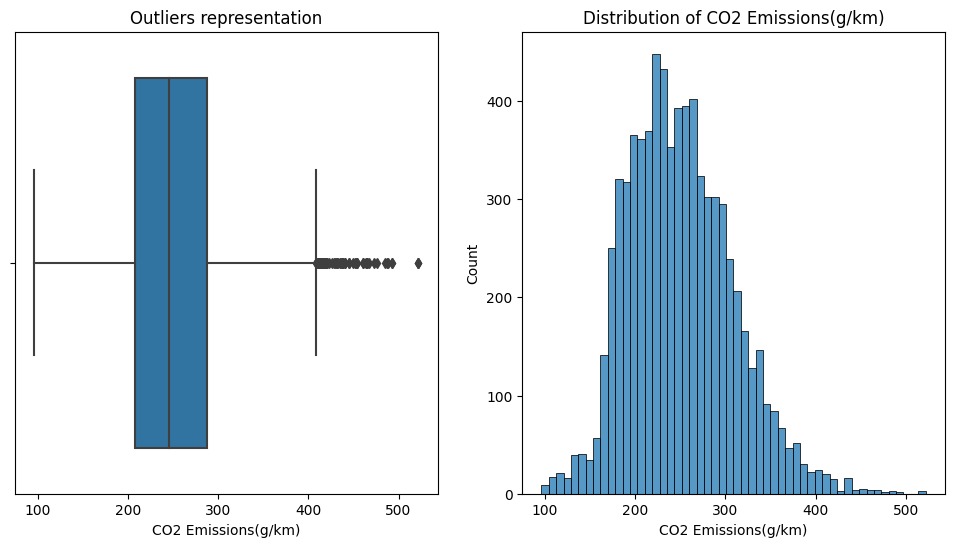

In [15]:
# box plot for CO2 emissions 
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot number 1
sns.boxplot(x = emissions['CO2 Emissions(g/km)'])
plt.title('Outliers representation')

# histplot for normal distribution of the CO2 values
plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot no. 2
sns.histplot(x = emissions['CO2 Emissions(g/km)'])
plt.title('Distribution of CO2 Emissions(g/km)')
plt.show()

- There seem to be some outliers and the data seems normally distributed, slightly skewed to the left.

## Remove outliers

I will calculate the z-score for each data point, where the z-score indicates how many standard deviations a data point is from the mean. 

In [16]:
from scipy import stats

z_scores = stats.zscore(emissions['CO2 Emissions(g/km)'])
# select rows where absolute Z-score is less than 3
emissions = emissions[abs(z_scores) < 2.6]

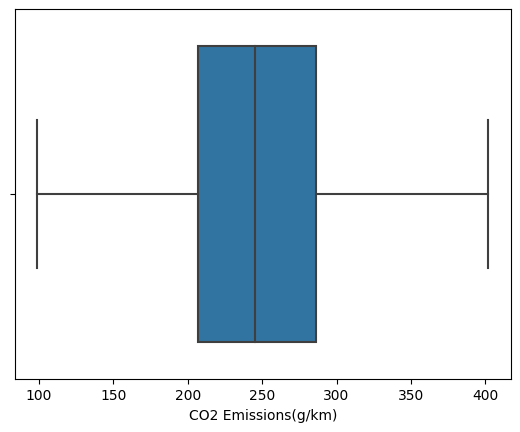

In [17]:
sns.boxplot(x = emissions['CO2 Emissions(g/km)'])
plt.show()

- Outliers removed. Let's look at the data distribution again.

In [18]:
emissions.isnull().sum().any()

False

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


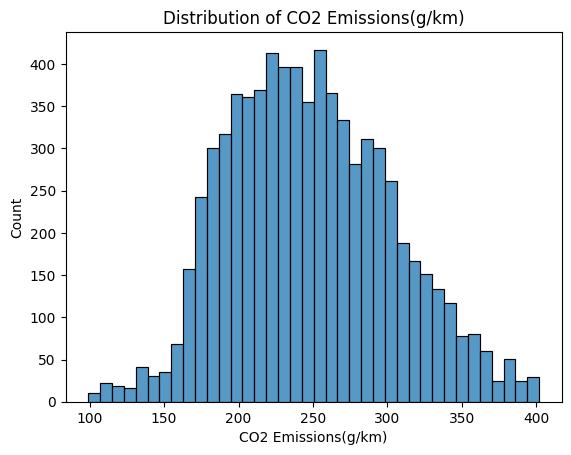

In [19]:
sns.histplot(x = emissions['CO2 Emissions(g/km)'])
plt.title('Distribution of CO2 Emissions(g/km)')
plt.show()

- Now, the data is normally distributed around the mean (250).

## CO2 emissions on average by vehicle model

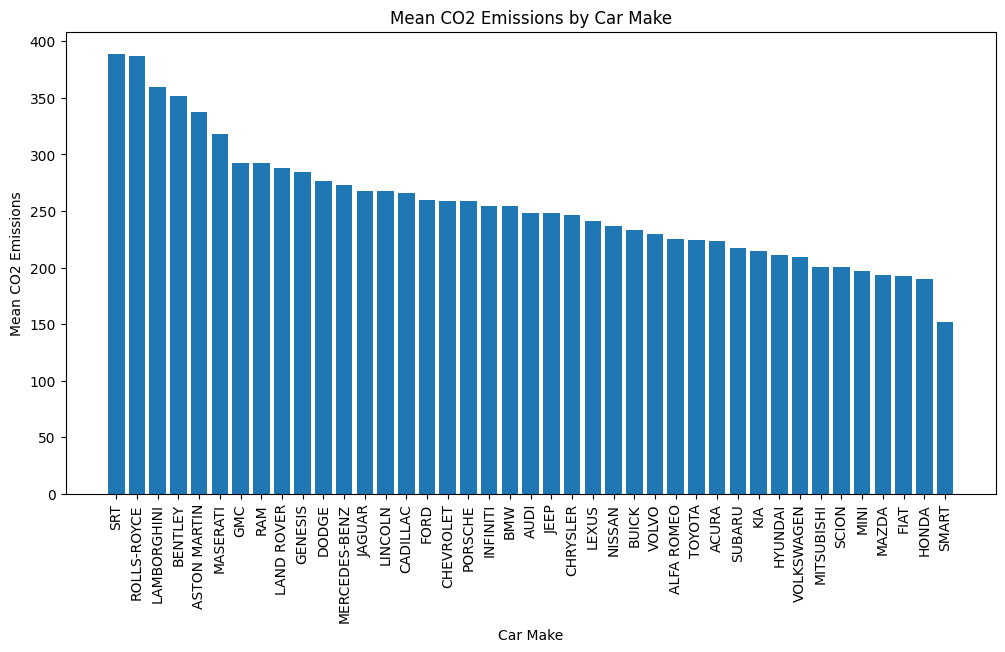

In [20]:
plt.figure(figsize = (12, 6))
mean_emissions_by_make = emissions.groupby('Make')['CO2 Emissions(g/km)'].mean().sort_values(ascending=False)
plt.bar(mean_emissions_by_make.index, mean_emissions_by_make) # the indexes are the unique car makes 
plt.title("Mean CO2 Emissions by Car Make")
plt.xlabel("Car Make")
plt.ylabel("Mean CO2 Emissions")
plt.xticks(rotation = 90)  # rotate x-axis labels 
plt.show()

- What about the number of cars each company registered in this dataset?

In [21]:
emissions['Make'].nunique()

41

- There are 41 companies in the dataset. I will make a bar plot with all of them, in ascending order by the number of cars each has produced and registered here.

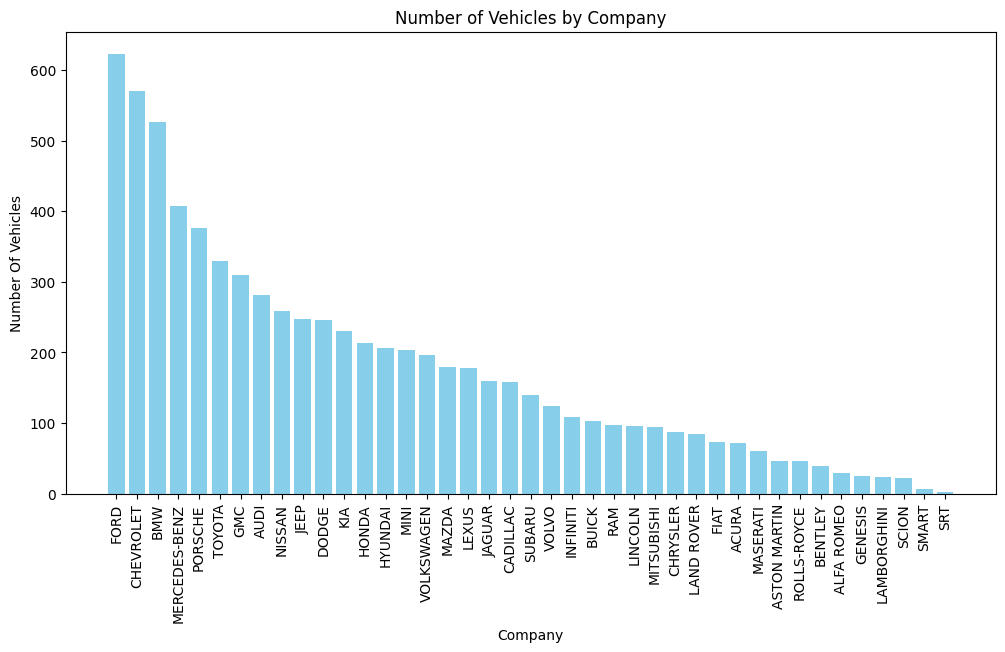

In [22]:
emissions_make = emissions['Make'].value_counts()

# Create a bar plot for all unique companies
plt.figure(figsize=(12, 6))  # Adjust the figure size if needed
plt.bar(emissions_make.index, emissions_make, color = 'skyblue')

plt.title('Number of Vehicles by Company')
plt.xlabel('Company')
plt.ylabel('Number Of Vehicles')
plt.xticks(rotation = 90)  
plt.show()

- Data is somehow scattered and for instance, even though Ford has the highest number of cars in this dataset, it falls in the middle regarding the average CO2 emissions. However, 600 cars * 270 g/km is a pretty high number indicating the CO2 emissions. 

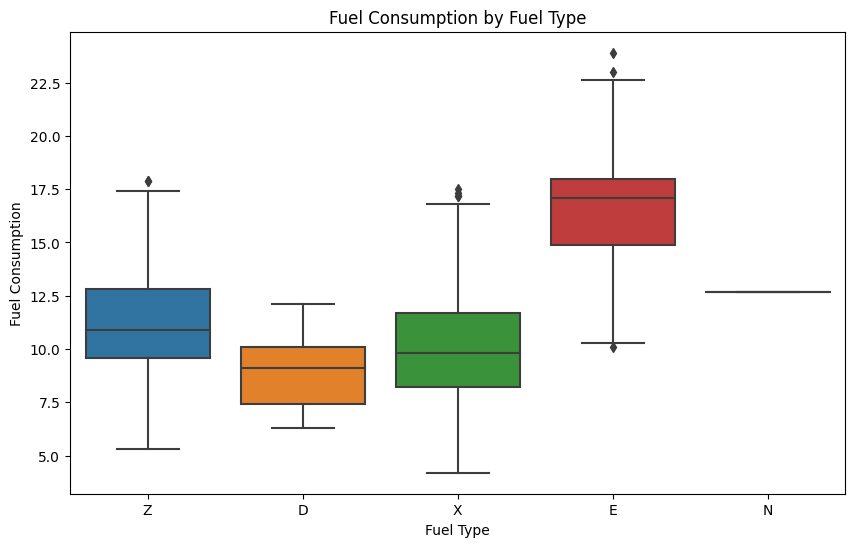

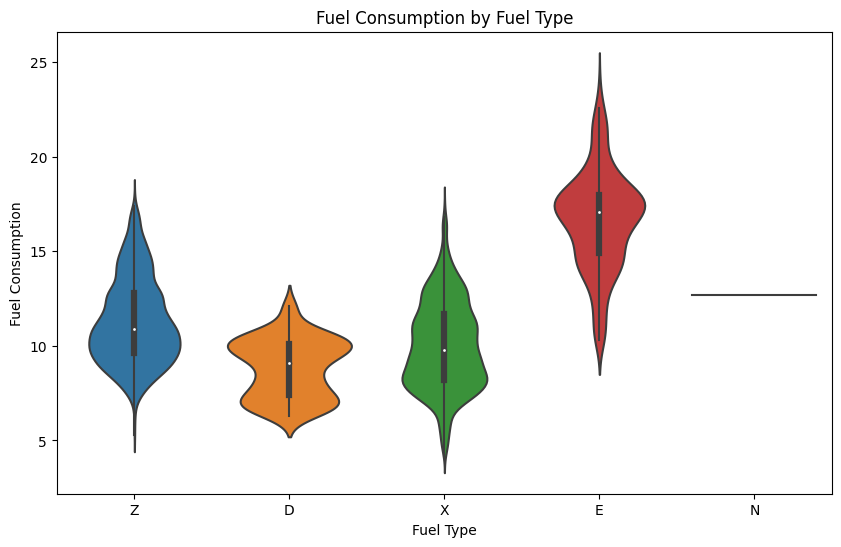

In [23]:
plt.figure(figsize = (10, 6))

# box plot
sns.boxplot(x = 'Fuel Type', y = 'Fuel Consumption Comb (L/100 km)', data = emissions)
plt.title('Fuel Consumption by Fuel Type')
plt.xlabel('Fuel Type')
plt.ylabel('Fuel Consumption')
plt.show()

# violin plot
plt.figure(figsize = (10, 6))
sns.violinplot(x = 'Fuel Type', y = 'Fuel Consumption Comb (L/100 km)', data = emissions)
plt.title('Fuel Consumption by Fuel Type')
plt.xlabel('Fuel Type')
plt.ylabel('Fuel Consumption')
plt.show()

In [24]:
emissions.shape

(7289, 11)

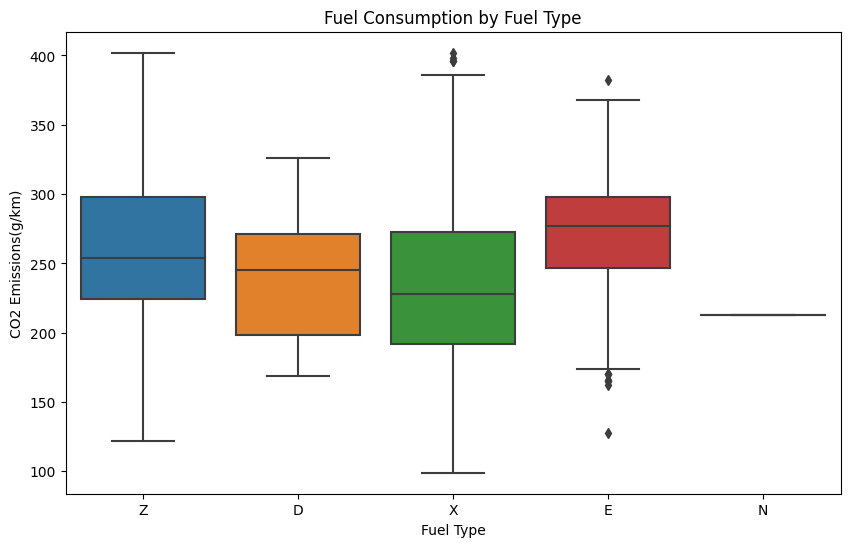

In [25]:
plt.figure(figsize = (10, 6))

# box plot
sns.boxplot(x = 'Fuel Type', y = 'CO2 Emissions(g/km)', data = emissions)
plt.title('Fuel Consumption by Fuel Type')
plt.xlabel('Fuel Type')
plt.ylabel('CO2 Emissions(g/km)')
plt.show()

- We already know that fuel consumption is higher in the city than in the highways, but what about the type of fuel?

In [26]:
emissions.head()

,Make,Model,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),CO2 Emissions(g/km)
0,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,196
1,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,221
2,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,136
3,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,255
4,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,244


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

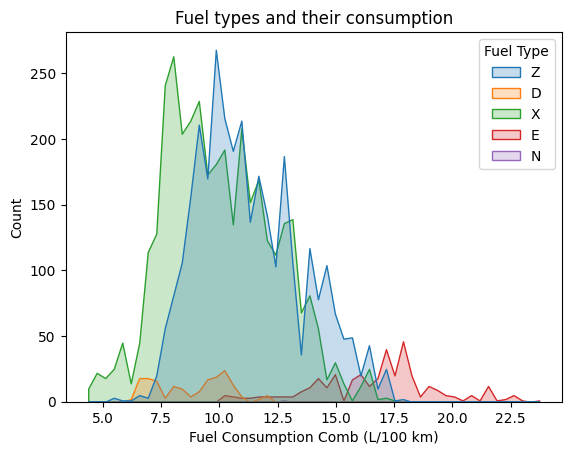

In [27]:
sns.histplot(emissions, x = "Fuel Consumption Comb (L/100 km)", hue = "Fuel Type", element = "poly")
plt.title('Fuel types and their consumption')
plt.show()

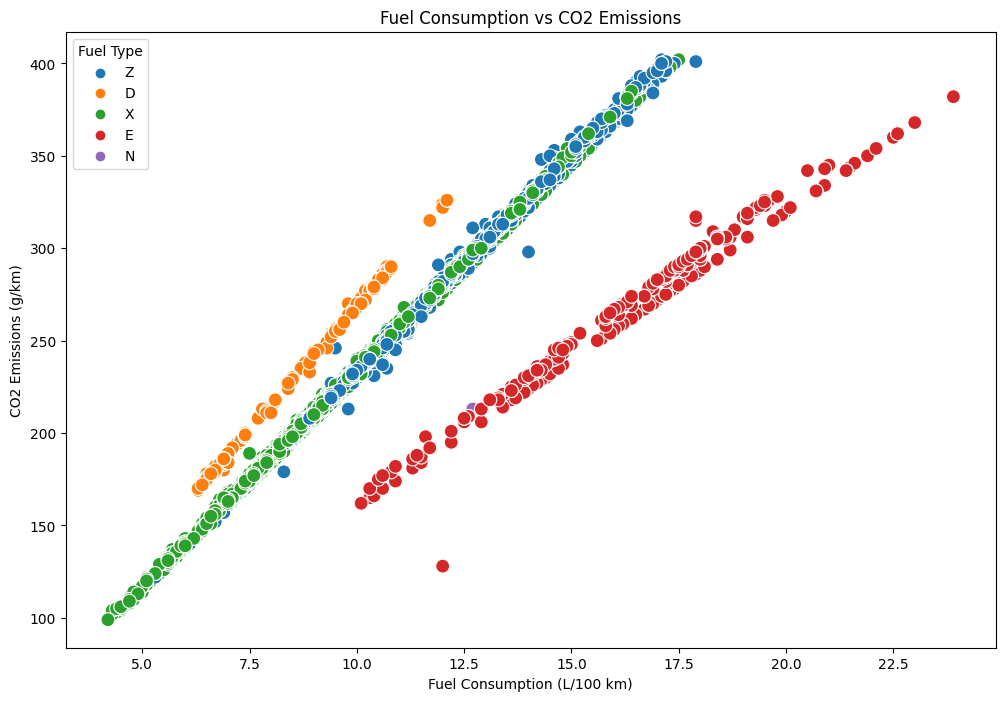

In [28]:
plt.figure(figsize=(12, 8))

sns.scatterplot(x = "Fuel Consumption Comb (L/100 km)", y = "CO2 Emissions(g/km)", data = emissions, hue = "Fuel Type", s = 100)
plt.title('Fuel Consumption vs CO2 Emissions')
plt.xlabel('Fuel Consumption (L/100 km)')
plt.ylabel('CO2 Emissions (g/km)')
plt.show()

- We can see that the highest fuel consumption corresponds to Ethanol usage, but still, despite its large usage, it doesn't produce more CO2 than the other fuels, most of the cars producing between 200-300 g/km CO2.

# One-hot encoding

- We need all the data to be numerical. 
- We can use either OneHotEncoder function from the scikit-learn library or get_dummies function pertaining to pandas.

In [29]:
n_values_count = emissions['Fuel Type'].value_counts()

# Display the count of 'N' values
print("Number of 'N' values in the 'Fuel Type' column:", n_values_count.get('N', 0))

Number of 'N' values in the 'Fuel Type' column: 1


In [30]:
emissions_with_dummies = emissions.copy()
emissions_to_dummies = ['Make','Vehicle Class','Cylinders','Transmission','Fuel Type']

# corresponding column prefixes used for one-hot encoding
prefix_for_emissions = ['Make','Cls','Cyl','Trans','F']


# display unique values of categorical columns before encoding
print("Unique values before encoding: ")
for column in emissions_to_dummies:
    print(column, ":", emissions[column].unique())


# one-hot enc in a loop
for column, pref in zip(emissions_to_dummies, prefix_for_emissions):
    # prefix parameter adds a prefix to the new column names
    # drop_first = True parameter is used to avoid the dummy variable trap by dropping the first dummy variable, to prevent multicollinearity issues
    dummy = pd.get_dummies(emissions_with_dummies[column], prefix = pref, drop_first = True)
    
    # join the encoded columns with the original df
    emissions_with_dummies = emissions_with_dummies.join(dummy)

# assign the target var 
labels = emissions_with_dummies['CO2 Emissions(g/km)']

# columns that will be dropped from the df 
emissions_to_drop = emissions_to_dummies + ['Model', 'CO2 Emissions(g/km)']

print(emissions_to_drop)

Unique values before encoding: 
Make : ['ACURA' 'ALFA ROMEO' 'ASTON MARTIN' 'AUDI' 'BENTLEY' 'BMW' 'BUICK'
 'CADILLAC' 'CHEVROLET' 'CHRYSLER' 'DODGE' 'FIAT' 'FORD' 'GMC' 'HONDA'
 'HYUNDAI' 'INFINITI' 'JAGUAR' 'JEEP' 'KIA' 'LAMBORGHINI' 'LAND ROVER'
 'LEXUS' 'LINCOLN' 'MASERATI' 'MAZDA' 'MERCEDES-BENZ' 'MINI' 'MITSUBISHI'
 'NISSAN' 'PORSCHE' 'RAM' 'ROLLS-ROYCE' 'SCION' 'SMART' 'SRT' 'SUBARU'
 'TOYOTA' 'VOLKSWAGEN' 'VOLVO' 'GENESIS']
Vehicle Class : ['COMPACT' 'SUV - SMALL' 'MID-SIZE' 'TWO-SEATER' 'MINICOMPACT'
 'SUBCOMPACT' 'FULL-SIZE' 'STATION WAGON - SMALL' 'SUV - STANDARD'
 'VAN - CARGO' 'VAN - PASSENGER' 'PICKUP TRUCK - STANDARD' 'MINIVAN'
 'SPECIAL PURPOSE VEHICLE' 'STATION WAGON - MID-SIZE'
 'PICKUP TRUCK - SMALL']
Cylinders : [ 4  6 12  8 10  3  5]
Transmission : ['AS5' 'M6' 'AV7' 'AS6' 'AM6' 'A6' 'AM7' 'AV8' 'AS8' 'A7' 'A8' 'M7' 'A4'
 'M5' 'AV' 'A5' 'AS7' 'A9' 'AS9' 'AV6' 'AS4' 'AM5' 'AM8' 'AM9' 'AS10'
 'A10' 'AV10']
Fuel Type : ['Z' 'D' 'X' 'E' 'N']
['Make', 'Vehicle Class', 'C

In [31]:
# drop columns identified in emissions_to_drop
final_emissions = emissions_with_dummies.drop(emissions_to_drop, axis = 1)

# display unique values of categorical columns after encoding
print("\nUnique values after encoding:")
encoded_columns = [col for col in final_emissions.columns if any(col.startswith(prefix) for prefix in emissions_to_dummies)]
for column in encoded_columns:
    print(column, ":", final_emissions[column].unique())


Unique values after encoding:
Make_ALFA ROMEO : [False  True]
Make_ASTON MARTIN : [False  True]
Make_AUDI : [False  True]
Make_BENTLEY : [False  True]
Make_BMW : [False  True]
Make_BUICK : [False  True]
Make_CADILLAC : [False  True]
Make_CHEVROLET : [False  True]
Make_CHRYSLER : [False  True]
Make_DODGE : [False  True]
Make_FIAT : [False  True]
Make_FORD : [False  True]
Make_GENESIS : [False  True]
Make_GMC : [False  True]
Make_HONDA : [False  True]
Make_HYUNDAI : [False  True]
Make_INFINITI : [False  True]
Make_JAGUAR : [False  True]
Make_JEEP : [False  True]
Make_KIA : [False  True]
Make_LAMBORGHINI : [False  True]
Make_LAND ROVER : [False  True]
Make_LEXUS : [False  True]
Make_LINCOLN : [False  True]
Make_MASERATI : [False  True]
Make_MAZDA : [False  True]
Make_MERCEDES-BENZ : [False  True]
Make_MINI : [False  True]
Make_MITSUBISHI : [False  True]
Make_NISSAN : [False  True]
Make_PORSCHE : [False  True]
Make_RAM : [False  True]
Make_ROLLS-ROYCE : [False  True]
Make_SCION : [False  

In [32]:
final_emissions

,Engine Size(L),Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Make_ALFA ROMEO,Make_ASTON MARTIN,Make_AUDI,Make_BENTLEY,Make_BMW,Make_BUICK,...,Trans_AV6,Trans_AV7,Trans_AV8,Trans_M5,Trans_M6,Trans_M7,F_E,F_N,F_X,F_Z
0,2.0,9.9,6.7,8.5,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1,2.4,11.2,7.7,9.6,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,True
2,1.5,6.0,5.8,5.9,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,True
3,3.5,12.7,9.1,11.1,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,3.5,12.1,8.7,10.6,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7380,2.0,10.7,7.7,9.4,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
7381,2.0,11.2,8.3,9.9,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
7382,2.0,11.7,8.6,10.3,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
7383,2.0,11.2,8.3,9.9,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


In [33]:
# final_emissions.replace({False: 0, True: 1}, inplace = True)
# final_emissions

# Modeling

## Linear Regression

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


X_train, X_test, y_train, y_test = train_test_split(final_emissions, labels, test_size = 0.2, random_state = 0)

lin_reg_enc = LinearRegression().fit(X_train, y_train)
print('The coefficient of determination (R^2) of the prediction, for continuous variables only linear regressions model: ')
print(lin_reg_enc.score(X_test, y_test))

The coefficient of determination (R^2) of the prediction, for continuous variables only linear regressions model: 
0.99285920761668


- 99.28% of the difference in CO2 emissions can be explained by this linear regressions model.

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

numerical_columns=emissions.select_dtypes(exclude=['object']).columns

y = emissions['CO2 Emissions(g/km)']
X = emissions[numerical_columns].drop('CO2 Emissions(g/km)',axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size = 0.2, random_state = 0)

lin_reg = LinearRegression().fit(X_train, y_train)
lin_reg.score(X_test, y_test)

0.8766408705729646

> The difference between the linear regression model that uses both continuous and categorical variables is considerable in comparison with the model that uses encoded variables (all being continuous), in regards to the coefficient of determination.
- A value of 0.99 means that the model explains almost perfectly all the variability of the response data around the mean (99.28% of the variance in the target variable is predictable from the features, where variance means how much the values in the dataset differ from the mean value; in other words, the variance measure the spread of the data points).

## KNN

In [36]:
from sklearn.neighbors import KNeighborsRegressor

X_train, X_test, y_train, y_test = train_test_split(final_emissions, labels, test_size = 0.2, random_state = 0)

knn = KNeighborsRegressor().fit(X_train, y_train)

knn.score(X_train, y_train)

0.9931098616013303

## Random Forest

In [37]:
from sklearn.ensemble import RandomForestRegressor

X_train, X_test, y_train, y_test = train_test_split(final_emissions, labels, test_size = 0.2, random_state = 0)

rf = RandomForestRegressor(random_state = 0).fit(X_train, y_train)

rf.score(X_test, y_test)

0.9964109560482884

## Hyperparameters search

In [38]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.ensemble import RandomForestRegressor

# X_train, X_test, y_train, y_test = train_test_split(final_emissions, labels, test_size = 0.2, random_state = 0)


# param_grid = {
#     'n_estimators': [50, 100, 200],  # no. of trees in the forest
#     'max_depth': [None, 10, 20, 30],  # max depth of the trees
#     'min_samples_split': [2, 5, 10],   # min no. of samples required to split a node
#     'min_samples_leaf': [1, 2, 4]      # min no. of samples required at each leaf node
# }

# grid_search = GridSearchCV(RandomForestRegressor(random_state = 0), param_grid, cv=5)

# grid_search.fit(X_train, y_train)

# print("Best hyperparameters:", grid_search.best_params_)
# print("Best score:", grid_search.best_score_)

# best_rf = grid_search.best_estimator_
# best_rf.score(X_test, y_test)

In [39]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.neighbors import KNeighborsRegressor
# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(final_emissions, labels, test_size = 0.2, random_state = 0)

# # parameter grid for KNN
# param_grid = {
#     'n_neighbors': [3, 5, 7, 9, 11],     # no. of neighbors to consider
#     'weights': ['uniform', 'distance'],  # weight function used in prediction
#     'p': [1, 2],                          # power parameter for Minkowski distance, 1 for manhattan, 2 for euclidean)
#     'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # algorithm used to compute the nearest neighbors
#     'leaf_size': [10, 20, 30, 40],        # leaf size passed 
#     'metric': ['euclidean', 'manhattan']  # distance metric to use for the tree
# }

# # initialize gridsearchcv object for KNN
# grid_search = GridSearchCV(KNeighborsRegressor(), param_grid, cv = 5)

# # fit the grsearch object to the training data
# grid_search.fit(X_train, y_train)

# print("Best hyperparameters:", grid_search.best_params_)

# # the best score (mean cross-validated score) on the training data
# print("Best score:", grid_search.best_score_)

# # retrieve the best estimator from the grsearchcv object
# best_knn = grid_search.best_estimator_

# # the R^2 score of the best estimator on the test data
# print("Test score:", best_knn.score(X_test, y_test))


## Models comparison

In [40]:
scores = {
    "Linear Regression": lin_reg_enc.score(X_test, y_test),
    "KNN": knn.score(X_test, y_test),
    "Random Forest": rf.score(X_test, y_test)
}

scores_df = pd.DataFrame(scores, index=["R^2 Score"])

# transpose the df to have models as rows and metrics as columns
scores_df = scores_df.T

print(scores_df)

                   R^2 Score
Linear Regression   0.992859
KNN                 0.988426
Random Forest       0.996411
